#CafChem tools for building a GPT model, or fine-tuning a GPT model to produce molecules based on a user-provided dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/GPT_CafChem.ipynb)

## This notebook allows you to:
- Read in a CSV file with SMILES strings and tokenize it.
- Train or finetune a GPT on this dataset.
- Save the GPT for future use.
- upload a saved GPT.
- test the GPT by generating sample molecules
- Run large-scale inference to generate up to 5K molecules.

## Requirements:
- This notebook will install deepchem
- It will pull the CafChem tools from Github.
- It will install all needed libraries.


## Set-up

This block:

- Loads all needed modules/libraries
    
- pulls CafChem from github

In [1]:
!pip install deepchem --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 84.2 MB/s eta 0:00:00


In [8]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 703, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 703 (delta 113), reused 54 (delta 54), pack-reused 571 (from 2)
Receiving objects: 100% (703/703), 41.88 MiB | 22.46 MiB/s, done.
Resolving deltas: 100% (401/401), done.


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
import CafChem.CafChemGPT as ccgpt

print("All libraries loaded!")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


All libraries loaded!


## Tokenize
- Create the tokenizer (right now the vocabulary is limited to 100 tokens). You can test the compapibility of your dataset with the vocabulary below.
- Create the input and target arrays for training.

In [4]:
fx, fy, VOCAB_SIZE, tokenizer, max_length = ccgpt.make_datasets("/content/905-unique-statins.csv", "Ligand SMILES")

118 20
Vocabulary size for this dataset:  100
Number of features and datapoints, targets:  (905, 117) (905, 117)
featurization done with:  SMILES Tokenizer


In [5]:
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Max length: {max_length}")

Vocabulary size: 100
Max length: 118


## Training the model

- This block defines the sequential model and runs the optimization.

- can load previous weights

In [ ]:
gpt = ccgpt.make_gpt(2, max_length, VOCAB_SIZE)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, None, 256)      │        55,808 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,450,532 (9.35 MB)

 Trainable params: 2,450,532 (9.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 512
gpt.compile("adam",loss=[tf.keras.losses.SparseCategoricalCrossentropy(),None])
gpt.fit(fx,fy,epochs = 2, batch_size = batch_size)

Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 22s/step - loss: 4.1133
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 1.1051


## saving
- saves both the model weights and the layer names (in a txt file). These are needed for loading later.

In [ ]:
gpt.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, None, 256)      │        55,808 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,351,598 (28.04 MB)

 Trainable params: 2,450,532 (9.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,901,066 (18.70 MB)

In [ ]:
ccgpt.save_gpt(gpt, "GPT_statin_2epochs")

New layer names:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1_original          │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1… │ (None, None, 256)      │        55,808 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2_original    │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3_original    │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9_original (Dense)        │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,351,598 (28.04 MB)

 Trainable params: 2,450,532 (9.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,901,066 (18.70 MB)

model saved with name: GPT_statin_2epochs.
layer names saved in file: layer_store_GPT_statin_2epochs.


## Set up Xfer learning
- first, upload a training set and test the vocabulary to see if your dataset is compatible with the Foundation model usedfor fine-tuning. It will check if you dataset has any token not included in the foundation model, and check to see if the context window for your dataset is within the context window for the foundation model.
- if it is compatible, tokenize your dataset.
- then create a new model that has 2 transformer blocks/layers pre-loaded from the foundation model, with a user-specified number of new blocks for fine-tuning. By default the old blocks are frozen for training, but you can toggle this.
- (optionally unfreeze the old blocks/layers)
- finally train the model. About 50 epochs of training minumum are usually required for fine-tuning. Model should be trained first with the foundation layers frozen, and then again with them unfrozen.
- The foundation model is a 2 transformer block model trained on 305K SMILES from the ZN database. Of those, at least 55K are drug-like.

In [ ]:
novel_tokens = ccgpt.test_vocab("/content/905-unique-statins.csv", "Ligand SMILES")

118 20
New vocabulary size:  35
Vocabulary size for standard dataset:  100
This dataset is compatible with the Foundation model vocabulary
This dataset's context window is compatible with the Foundation model


In [ ]:
fx, fy, VOCAB_SIZE, tokenizer, max_length = ccgpt.make_datasets("/content/905-unique-statins.csv", "Ligand SMILES")

118 20
Vocabulary size for this dataset:  100
Number of features and datapoints, targets:  (905, 117) (905, 117)
featurization done with:  SMILES Tokenizer


In [ ]:
gpt_2x_2 = ccgpt.make_finetune_gpt(2, freeze_old_layers=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_2  │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_8             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_9             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,831,844 (18.43 MB)

 Trainable params: 4,831,844 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

Reading in layers:
input_layer_original
token_and_position_embedding_original
transformer_block_original
transformer_block_1_original
dense_4_original
input_layer_original has been named!
token_and_position_embedding_original has been named!
transformer_block_original has been named!
transformer_block_1_original has been named!
transformer_block_X_1 has been named!
transformer_block_X_2 has been named!
setting layer input_layer_original untrainable.
setting layer token_and_position_embedding_original untrainable.
setting layer transformer_block_original untrainable.
setting layer transformer_block_1_original untrainable.
setting layer transformer_block_X_1 trainable.
setting layer transformer_block_X_2 trainable.
setting layer dense_X trainable.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:629: UserWarning: A total of 16 objects could not be loaded. Example error message for object <EinsumDense name=key, built=True>:

Layer 'key' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <Dense name=dense_18, built=True>, <Dense name=dense_19, built=True>, <LayerNormalization name=layer_normalization_16, built=True>, <LayerNormalization name=layer_normalization_17, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <Dense name=dense_20, built=True>, <Dense name=dense_21, built=True>, <LayerNormalization name=layer_normalization_18, built=True>, <L

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_original            │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_o… │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_original      │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1_original    │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_1           │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_2           │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_X (Dense)                 │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,831,844 (18.43 MB)

 Trainable params: 2,394,724 (9.14 MB)

 Non-trainable params: 2,437,120 (9.30 MB)

In [ ]:
gpt_2x_2 = ccgpt.unfreeze_gpt(gpt_2x_2)

setting layer input_layer_original_original trainable.
setting layer token_and_position_embedding_original_original trainable.
setting layer transformer_block_original_original trainable.
setting layer transformer_block_1_original_original trainable.
setting layer transformer_block_X_1_original trainable.
setting layer transformer_block_X_2_original trainable.
setting layer dense_X_original trainable.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_original_original   │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_o… │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_original_ori… │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1_original_o… │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_1_original  │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_2_original  │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_X_original (Dense)        │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,621,294 (36.70 MB)

 Trainable params: 4,831,844 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,789,450 (18.27 MB)

In [ ]:
batch_size = 512
gpt_2x_2.compile("adam",loss=[tf.keras.losses.SparseCategoricalCrossentropy(),None])

gpt_2x_2.fit(fx,fy,epochs = 75, batch_size = batch_size)

Epoch 1/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 14s/step - loss: 0.4795
Epoch 2/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - loss: 0.8252
Epoch 3/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - loss: 0.5455
Epoch 4/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - loss: 0.4222
Epoch 5/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - loss: 0.3697
Epoch 6/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - loss: 0.3265
Epoch 7/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - loss: 0.2904
Epoch 8/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - loss: 0.2664
Epoch 9/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - loss: 0.2406
Epoch 10/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - loss: 0.2268
Epoch 11/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - loss: 0.2131
Epoch 12/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - loss: 0.2008
Epoch 13/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - loss: 0.1909
Epoch 14/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - loss: 0.1830
Epoch 15/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - loss: 0.1761
Epoch 16/75
2/2 ━━━━

In [ ]:
ccgpt.save_gpt(gpt_2x_2, "GPT_statin_100p75epochs")

New layer names:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_original_original_… │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_o… │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_original_ori… │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1_original_o… │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_1_original… │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_2_original… │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_X_original_original       │ (None, None, 100)      │        25,700 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,495,534 (55.30 MB)

 Trainable params: 4,831,844 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,663,690 (36.86 MB)

model saved with name: GPT_statin_100p75epochs.
layer names saved in file: layer_store_GPT_statin_100p75epochs.


## Standard molecule prediction

This block

- Accepts a model and generates a sample of up to 5 molecules as a quick test for the model.
- you can load just the foundation model to use, or
- use any other model.


In [ ]:
gpt_found = ccgpt.load_foundation()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_7  │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_18            │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_19            │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,462,820 (9.39 MB)

 Trainable params: 2,462,820 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

input_layer_original
token_and_position_embedding_original
transformer_block_original
transformer_block_1_original
dense_4_original
input_layer_original has been named!
token_and_position_embedding_original has been named!
transformer_block_original has been named!
transformer_block_1_original has been named!
dense_4_original has been named!
Foundation model loaded.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_original            │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_o… │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_original      │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1_original    │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4_original (Dense)        │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,462,820 (9.39 MB)

 Trainable params: 2,462,820 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
pic = ccgpt.test_gen(loaded_model,tokenizer,1.0,VOCAB_SIZE, 42)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
using variable temp generation with 1.0.
(5, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
using variable temp generation with 1.0.
(5, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
using variable temp generation with 1.0.
(5, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
using variable temp generation with 1.0.
(5, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
using variable temp generation with 1.0.
(5, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
using variable temp generation with 1.0.
(5, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
using variable temp generation with 1.0.
(5, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
using variable temp generation with 1.0.
(5, 11)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
using variable temp generation with 1.0.
(5, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
using variable temp generation with 1.0.
(5, 13)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
using variable temp generation with 1.0.
(5, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
using variable temp generation with

[14:51:13] SMILES Parse Error: extra close parentheses while parsing: O=C)(O
[14:51:13] SMILES Parse Error: check for mistakes around position 4:
[14:51:13] O=C)(O
[14:51:13] ~~~^
[14:51:13] SMILES Parse Error: Failed parsing SMILES 'O=C)(O' for input: 'O=C)(O'
[14:51:13] SMILES Parse Error: unclosed ring for input: 'c1C[C@@H](C)CC=O[C@@H](O)C=CC[C@H](O)CCCCCC[C@@H](O)CCCCCCCCC[C@@H](O)CCCCC[C@@H](O)CCCCCCCCCCCCCCCC[C@@H](=O)CCCCO'
[14:51:13] SMILES Parse Error: unclosed ring for input: 'COC2C(=O)C1C[C@@H](=O)O'


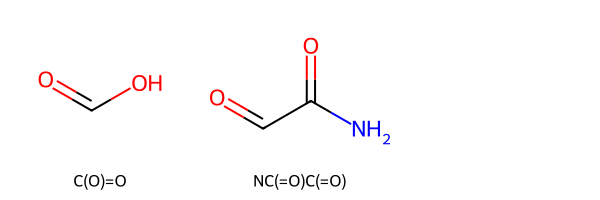

In [ ]:
pic

## Inference
- Load any model: just provide the string of the model's filename, the total number of blocks, and the context window and vocabulary size (from a tokenization above).
- Create up to 5K prompts with a length up to the context window size. Prompt lengths less than 6 tokens are recommended.

In [ ]:
loaded_model = ccgpt.load_gpt("GPT_statin_50p50epochs", 4, max_length, VOCAB_SIZE)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, None, 256)      │        55,808 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,819,556 (18.39 MB)

 Trainable params: 4,819,556 (18.39 MB)

 Non-trainable params: 0 (0.00 B)

input_layer_original_original
token_and_position_embedding_original_original
transformer_block_original_original
transformer_block_1_original_original
transformer_block_X_1_original
transformer_block_X_2_original
dense_X_original
input_layer_original_original has been named!
token_and_position_embedding_original_original has been named!
transformer_block_original_original has been named!
transformer_block_1_original_original has been named!
transformer_block_X_1_original has been named!
transformer_block_X_2_original has been named!
dense_X_original has been named!
model loaded with name: GPT_statin_50p50epochs.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:629: UserWarning: A total of 1 objects could not be loaded. Example error message for object <Embedding name=embedding_1, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(118, 256), Received: value.shape=(166, 256). Target variable: <Variable path=token_and_position_embedding/embedding_1/embeddings, shape=(118, 256), dtype=float32, value=[[ 0.00586026  0.02549909 -0.01668755 ...  0.01431924  0.03529285
  -0.0207323 ]
 [ 0.01459343  0.00442465 -0.02189984 ... -0.03289183  0.02052143
  -0.0319335 ]
 [ 0.01121811  0.03087529 -0.00500876 ...  0.01700935 -0.01048886
  -0.03962914]
 ...
 [ 0.01277342 -0.01292776  0.01290892 ...  0.03752531 -0.04978475
   0.03956424]
 [ 0.0444732   0.02752994 -0.04745213 ... -0.02150863 -0.02401984
   0.00469465]
 [ 0.01194519  0.03437748  0.03889041 ... -0.03811717  0.03903479
  -0.01562298]]>

List of

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_original_original   │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_o… │ (None, None, 256)      │        55,808 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_original_ori… │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1_original_o… │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_1_original  │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_2_original  │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_X_original (Dense)        │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,819,556 (18.39 MB)

 Trainable params: 4,819,556 (18.39 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
loaded_model = ccgpt.load_foundation()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,462,820 (9.39 MB)

 Trainable params: 2,462,820 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

input_layer_original
token_and_position_embedding_original
transformer_block_original
transformer_block_1_original
dense_4_original
input_layer_original has been named!
token_and_position_embedding_original has been named!
transformer_block_original has been named!
transformer_block_1_original has been named!
dense_4_original has been named!
Foundation model loaded.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_original            │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_o… │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_original      │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1_original    │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4_original (Dense)        │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,462,820 (9.39 MB)

 Trainable params: 2,462,820 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
prompts = ccgpt.make_prompts(100,2)

In [11]:
pic, novel_smiles = ccgpt.gen_mols(prompts, True, loaded_model, tokenizer, 1.5, VOCAB_SIZE)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step  
using zero temp generation with 0.0005030251956997171.
(100, 3)
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 898ms/step
using zero temp generation with 0.0013665767916009681.
(100, 4)
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 865ms/step
using zero temp generation with 0.0037089347349521613.
(100, 5)
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 909ms/step
using zero temp generation with 0.010039276386427282.
(100, 6)
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 869ms/step
using variable temp generation with 0.026979314943137336.
(100, 7)
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 902ms/step
using variable temp generation with 0.07113880976635018.
(100, 8)
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 885ms/step
using variable temp generation with 0.1788043830331763.
(100, 9)
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
using variable temp generation with 0.40341213205499266.
(100, 10)
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
using variable temp generation with 0.75.
(100, 11)
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
using variable temp generation with 1.096587867

[09:32:08] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCCCC[C@@H](O)[C@@H]1CC[C@H]([C@@H](O)CC[C@H](O)C[C@@H](O)CC[C@@H](O)CCCC[C@@H](O)CC2=O)O1'
[09:32:08] Explicit valence for atom # 14 O, 3, is greater than permitted
[09:32:08] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCCCC/C=C[C@@H](O)[C@@H](CO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O)NC[C@@H](CCN1C)C[C@H]2O'
[09:32:08] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 30
[09:32:08] SMILES Parse Error: extra open parentheses while parsing: CCCCCCCCCCCC[C@H](O)[C@H]1CC[C@H]([C@H](O)[C@H]2CC[C@@H](CCCCCC[C@@H](O)CC2=C[C@@H](C)OC(=O)c2ccc(C[N+](=O)O)c(C)c2)C[C@@H]2O[C@H](N)[C@H](O
[09:32:08] SMILES Parse Error: check for mistakes around position 34:
[09:32:08] C@H](O)[C@H]1CC[C@H]([C@H](O)[C@H]2CC[C@@
[09:32:08] ~~~~~~~~~~~~~~~~~~~~^
[09:32:08] SMILES Parse Error: extra open parentheses while parsing: CCCCCCCCCCCC[C@H](O)[C@H]1CC[C@H]([C@H](O)[C@H]2CC[C@@H](CCCCCC[C@@H](O)CC2=C[C@@H](C)OC(=O)c2ccc(C[N+](=O)O)c(C

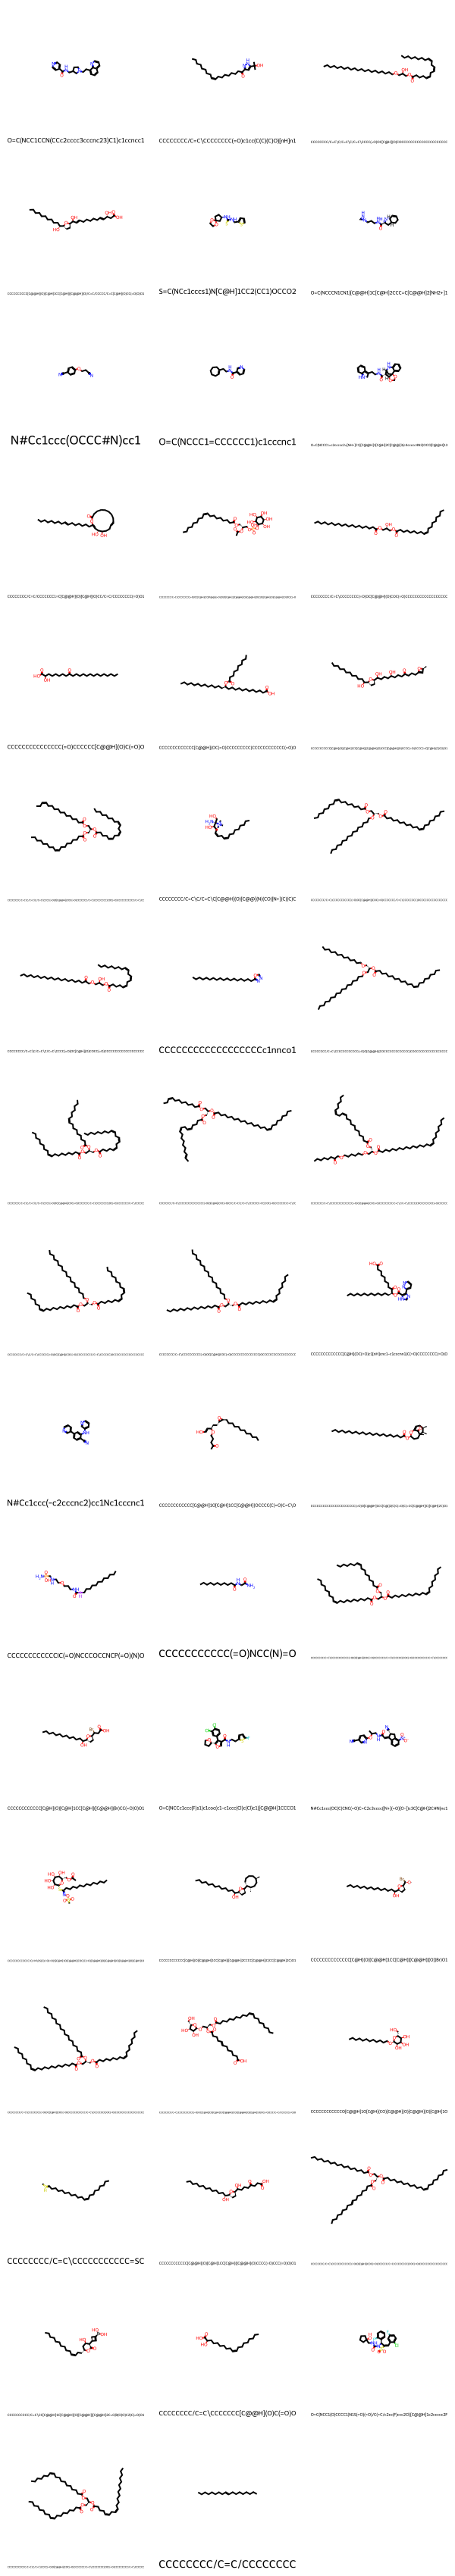

In [12]:
pic

## Create specific vocab list

- First block must be run before using this block. Then swap out the old vocab file for the new one and rerun
first block.
- reads in original vocab list
- uses the fl2set from the first block: this is a set with all unique tokens used in this model
- if a token is used, it is added to the new vocab list
- Note: [unused] must be added after [PAD] if it is not included

In [ ]:
#routine to create a smaller vocab_file based on the dataset using fl2set
oldvocab = open("vocab.txt","r")
oldvocab_lines = oldvocab.readlines()
oldvocab.close()

newvocab = open("vocab_350K.txt","w",newline="\n")

for i in range(len(oldvocab_lines)):
    if i in fl2set:
        print(oldvocab_lines[i])
        newvocab.write(oldvocab_lines[i])

newvocab.close()

[PAD]

[CLS]

[SEP]

c

C

(

)

O

1

2

=

N

n

3

F

Cl

-

4

[C@H]

S

[C@@H]

[O-]

Br

#

/

[nH]

[N+]

s

5

o

P

[Si]

I

B

[C@]

[C@@]

6

\

[N-]

[c-]

[O+]

7

[n+]

[Sn]

[CH]

[C-]

[B-]

[P+]

[C]

8

[nH+]

[NH3+]

[S@]

[S@@]

[S-]

[PH]

[NH2+]

[S+]

[NH+]

9

[cH-]

[O]

[SH]

[PH+]

[C+]

[SnH]

%10

[CH2-]

[n-]

[NH-]

[PH2]

%11

[N]

[P@]

[s+]

[CH-]

[CH+]

%12

[P@@]

[o+]

%13

[S@+]

[S@@+]

[SH+]

[OH+]

%14

%15

%16

[N@@+]

[N@+]

[125I]

%17

%18

%19

%20

%21

[P@@H]

[131I]

[P@H]



In [ ]:
rnd = random.